## Imports and Setup

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby

import seaborn as sns
sns.set(color_codes=True)

# bilby.utils.setup_logger(log_level = "WARNING")

## Parameter Estimation

### Simulating data

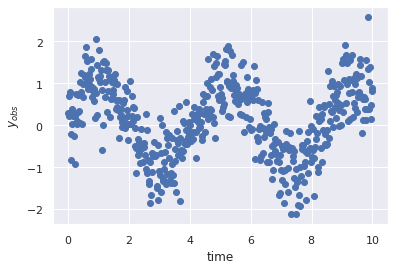

In [2]:
def modelA(time, omega):
    return np.sin(omega * time)

sigma = 0.5
omega_true = 1.5
time = np.linspace(0, 10, 500)
y = modelA(time, omega_true)
y_obs = y + np.random.normal(0, sigma, len(time))

plt.plot(time, y_obs, 'o')
plt.ylabel("$y_{obs}$")
plt.xlabel("time")
plt.show()

### Calculating likelihood

$$\ln{L} = -\frac{1}{2} \sum{\bigg(\frac{({y_{obs} - y_A})^2}{\sigma^2}+\ln{(2\pi\sigma^2)}\bigg)}$$

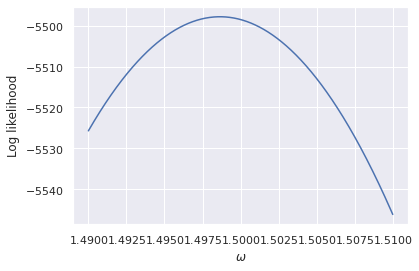

In [3]:
def ln_likelihood(y_obs, time, omega, sigma=0.1):
    yA = modelA(time, omega)
    r = -0.5 * (((y_obs - yA)**2 / sigma**2) + np.log(2*np.pi*sigma**2))
    return np.sum(r)

# omega_grid = np.linspace(0, 2, 1000)      # Rough idea for the interval where omega_true lies
omega_grid = np.linspace(omega_true-0.01, omega_true+0.01, 1000)
ln_likelihood_grid = []
for omega in omega_grid:
    ln_likelihood_grid.append(ln_likelihood(y_obs, time, omega))

plt.plot(omega_grid, ln_likelihood_grid)
plt.xlabel("$\omega$")
plt.ylabel("Log likelihood")
plt.show()

From this curve, we can see the $\omega$ with maximum likelihood.

### Fitting the curve

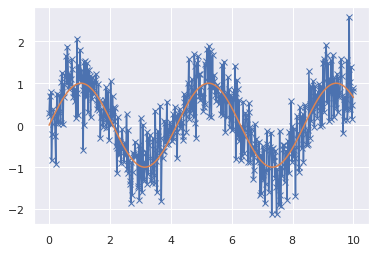

In [4]:
max_likelihood_omega = omega_grid[np.argmax(ln_likelihood_grid)]
max_likelihood_omega

y = modelA(time, max_likelihood_omega)
plt.plot(time, y_obs, '-x')
plt.plot(time, y)

### Posterior with constant prior

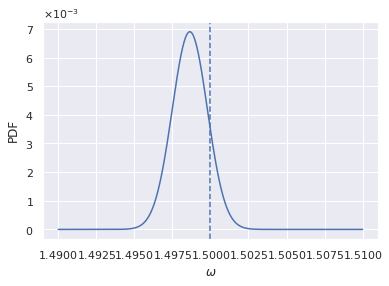

In [5]:
posterior_un = np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid))
posterior_norm = posterior_un / np.sum(posterior_un)
plt.plot(omega_grid, posterior_norm)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("PDF")
plt.show()

### Credible Intervals

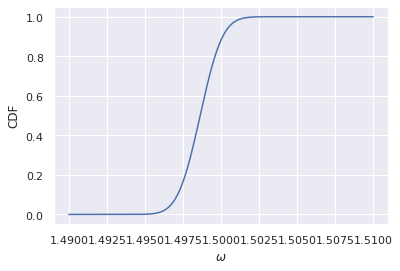

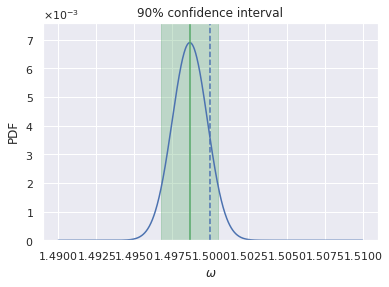

In [6]:
cdf = np.cumsum(posterior_norm)
plt.plot(omega_grid, cdf)
plt.xlabel('$\omega$')
plt.ylabel('CDF')
plt.show()

median = omega_grid[np.argmin(np.abs(cdf - 0.5))]
lower_bound = omega_grid[np.argmin(np.abs(cdf - 0.05))]
upper_bound = omega_grid[np.argmin(np.abs(cdf - 0.95))]

plt.plot(omega_grid, posterior_norm)
plt.axvline(omega_true, ls='--')
plt.fill_between([lower_bound, upper_bound], 0, 2 * np.max(posterior_norm), color = 'C2', alpha = 0.3)
plt.axvline(median, ls = '-', color = 'C2')
plt.ylim(0, 1.1*np.max(posterior_norm))
plt.xlabel('$\omega$')
plt.ylabel('PDF')
plt.title('90% confidence interval')
plt.show()

### Peak Finding Algorithm - Very Basic one

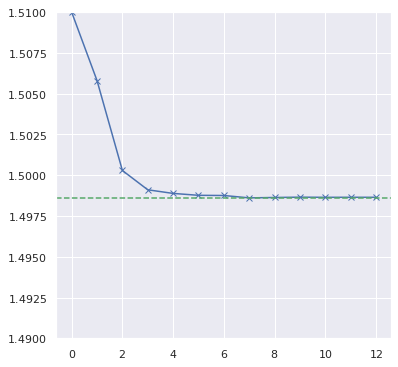

In [7]:
omega_values = [1.51]
ln_likelihood_values = [ln_likelihood(y_obs, time, omega_values[0])]

for i in range(10000):
    omega_proposed = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(y_obs, time, omega_proposed)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1]:
        omega_values.append(omega_proposed)
        ln_likelihood_values.append(ln_likelihood_proposed)

plt.figure(figsize = (6, 6))
plt.plot(omega_values, '-x')
plt.ylim(1.49, 1.51)
plt.axhline(median, ls = '--', color = 'C2')
plt.show()

## MCMC Sampler

A nice intuitive explanation can be found <a href = "https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50">here</a>. 

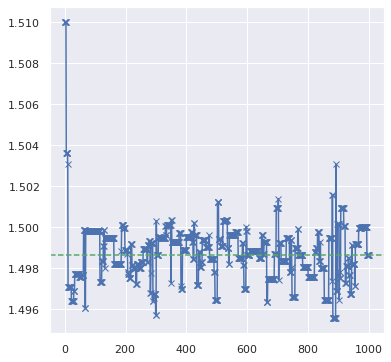

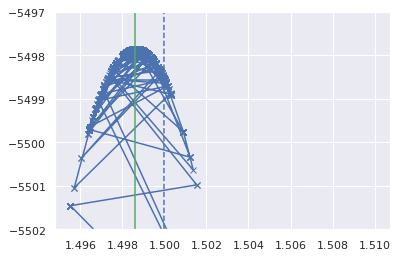

In [16]:
omega_values = [1.51]
ln_likelihood_values = [ln_likelihood(y_obs, time, omega_values[0])]

for i in range(1000):
    omega_proposed = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(y_obs, time, omega_proposed)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(omega_proposed)
        ln_likelihood_values.append(ln_likelihood_proposed)        
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])

med = np.mean(omega_values)
plt.figure(figsize = (6, 6))
plt.plot(omega_values, '-x')
plt.axhline(median, ls = '--', color = 'C2')
plt.show()   

plt.plot(omega_values, ln_likelihood_values, '-x')
plt.axvline(omega_true, ls='--')
plt.fill_between([lower_bound, upper_bound], 0, 2 * np.max(posterior_norm), color = 'C2', alpha = 0.3)
plt.axvline(median, ls = '-', color = 'C2')
plt.ylim(-5502, -5497)
plt.show()

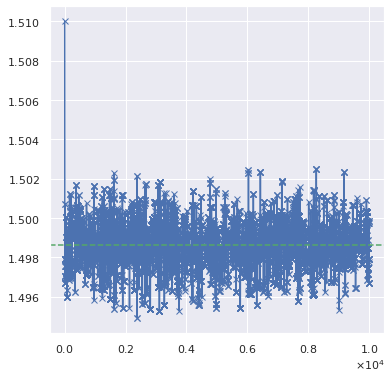

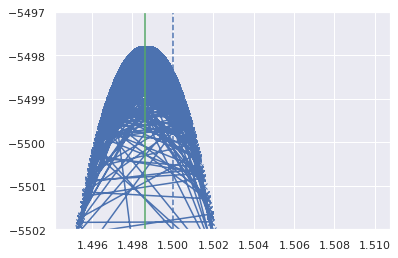

In [17]:
omega_values = [1.51]
ln_likelihood_values = [ln_likelihood(y_obs, time, omega_values[0])]

for i in range(10000):
    omega_proposed = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(y_obs, time, omega_proposed)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(omega_proposed)
        ln_likelihood_values.append(ln_likelihood_proposed)        
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])

med = np.mean(omega_values)
plt.figure(figsize = (6, 6))
plt.plot(omega_values, '-x')
plt.axhline(median, ls = '--', color = 'C2')
plt.show()   

plt.plot(omega_values, ln_likelihood_values, '-x')
plt.axvline(omega_true, ls='--')
plt.fill_between([lower_bound, upper_bound], 0, 2 * np.max(posterior_norm), color = 'C2', alpha = 0.3)
plt.axvline(median, ls = '-', color = 'C2')
plt.ylim(-5502, -5497)
plt.show()

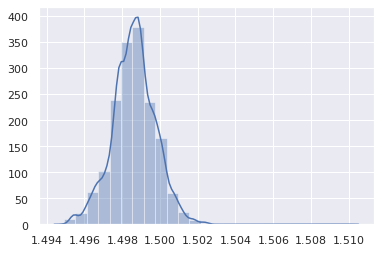

In [18]:
sns.distplot(omega_values, bins=25)

## Using Bilby to do all this

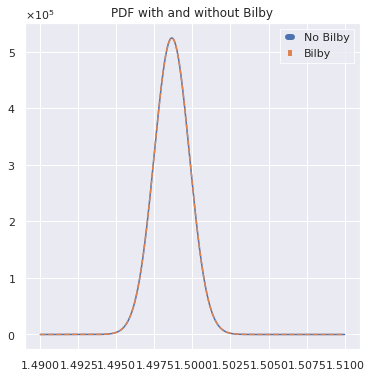

In [19]:
likelihood_bilby = bilby.likelihood.GaussianLikelihood(time, y_obs, modelA, sigma=0.1)
ln_likelihood_grid_bilby = []

for omega in omega_grid:
    likelihood_bilby.parameters["omega"] = omega
    ln_likelihood_grid_bilby.append(likelihood_bilby.log_likelihood())

plt.figure(figsize = (6,6))
plt.plot(omega_grid, np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid)), label = 'No Bilby')    
plt.plot(omega_grid, np.exp(ln_likelihood_grid_bilby - np.mean(ln_likelihood_grid_bilby)), ls = '--', label = 'Bilby') 
plt.title('PDF with and without Bilby')
plt.legend()
plt.show()

### For a more complicated model

$$y_B = A \sin{(\omega t + \phi_0)}$$

In [20]:
def modelB(time, omega, A, phi_0):
    return A * np.sin((omega*time) + phi_0)

likelihood_bilby = bilby.core.likelihood.GaussianLikelihood(time, y_obs, modelB)

priors = dict(
    A = bilby.core.prior.Uniform(0, 2, "A"),
    omega = bilby.core.prior.Uniform(0.5, 2.0, "omega"),
    phi_0 = bilby.core.prior.Uniform(-np.pi, np.pi, "$phi_0$"),
    sigma = bilby.core.prior.Uniform(0, 2, "sigma"))

result = bilby.run_sampler(
    likelihood = likelihood_bilby, priors = priors, sample ='unif', outdir = "test-dir", 
    injection_parameters=dict(A=1, omega=omega_true, phi_0=0, sigma=sigma), clean=True)

02:29 bilby INFO    : Running for label 'label', output will be saved to 'test-dir'
02:29 bilby INFO    : Search parameters:
02:29 bilby INFO    :   A = Uniform(minimum=0, maximum=2, name='A', latex_label='A', unit=None, boundary=None)
02:29 bilby INFO    :   omega = Uniform(minimum=0.5, maximum=2.0, name='omega', latex_label='omega', unit=None, boundary=None)
02:29 bilby INFO    :   phi_0 = Uniform(minimum=-3.141592653589793, maximum=3.141592653589793, name='$phi_0$', latex_label='$phi_0$', unit=None, boundary=None)
02:29 bilby INFO    :   sigma = Uniform(minimum=0, maximum=2, name='sigma', latex_label='sigma', unit=None, boundary=None)
02:29 bilby INFO    : Single likelihood evaluation took 1.858e-04 s


0it [00:00, ?it/s]

02:29 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fd24c891f70>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
02:29 bilby INFO    : Checkpoint every check_point_delta_t = 600s
02:29 bilby INFO    : Using dynesty version 1.0.1
02:29 bilby INFO    : Generating initial points from the pri

17938it [00:27, 847.79it/s, bound:59 nc:  1 ncall:7.1e+04 eff:25.3% logz=-375.11+/-0.16 dlogz:0.100>0.1] 

02:30 bilby INFO    : Written checkpoint file test-dir/label_resume.pickle
02:30 bilby INFO    : Writing 3809 current samples to test-dir/label_samples.dat


17938it [00:38, 470.09it/s, bound:59 nc:  1 ncall:7.1e+04 eff:26.7% logz=-375.03+/-0.17 dlogz:0.000>0.1]



02:30 bilby INFO    : Sampling time: 0:00:26.486962
02:30 bilby INFO    : Summary of results:
nsamples: 18938
ln_noise_evidence:    nan
ln_evidence: -375.029 +/-  0.168
ln_bayes_factor:    nan +/-  0.168



## Using the result object

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


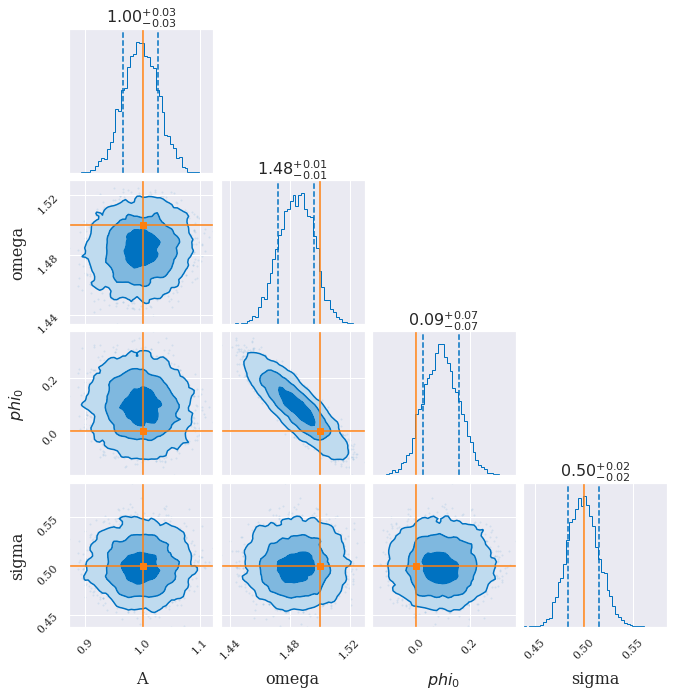

In [21]:
result.plot_corner()

In [22]:
print(result)

nsamples: 18938
ln_noise_evidence:    nan
ln_evidence: -375.029 +/-  0.168
ln_bayes_factor:    nan +/-  0.168



In [23]:
dir(result)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_prior_fixed_values_to_posterior',
 '_check_attribute_match_to_other_object',
 '_get_save_data_dictionary',
 '_kde',
 '_nburn',
 '_nested_samples',
 '_num_likelihood_evaluations',
 '_posterior',
 '_priors',
 '_safe_outdir_creation',
 '_samples',
 '_version',
 '_walkers',
 'bayesian_model_dimensionality',
 'calculate_prior_values',
 'constraint_parameter_keys',
 'covariance_matrix',
 'fixed_parameter_keys',
 'from_hdf5',
 'from_json',
 'get_all_injection_credible_levels',
 'get_injection_credible_level',
 'get_latex_labels_from_parameter_keys',
 'get_one_dimensional_median_and_error_bar',
 'get_weights_by_new_prior',


In [24]:
result.posterior.head()   # Samples from posterior distribution

,A,omega,phi_0,sigma,log_likelihood,log_prior
0,1.072314,1.473345,0.194326,0.438207,-374.305470,-3.629637
1,0.981349,1.476862,0.133148,0.585161,-371.776885,-3.629637
2,0.925136,1.520971,-0.098062,0.465484,-370.984540,-3.629637
3,1.040260,1.455197,0.349489,0.500727,-370.557947,-3.629637
4,0.894306,1.456244,0.309136,0.487283,-370.317531,-3.629637


### Using these samples
#### Omega Distribution

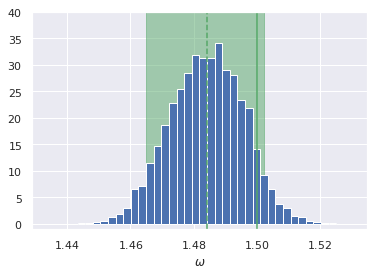

In [25]:
omega_samples = result.posterior["omega"]
omega_median = np.quantile(omega_samples, 0.5)
low_bound = np.quantile(omega_samples, 0.05)
up_bound = np.quantile(omega_samples, 0.95)

plt.hist(omega_samples, bins = 40, density = True)
plt.fill_between([low_bound, up_bound], 0, 60, color = 'C2', alpha = 0.5)
plt.axvline(omega_median, color = 'C2', ls='--')
plt.axvline(omega_true, color = 'C2', ls='-')
plt.ylim(-1, 40)
plt.xlabel('$\omega$')
plt.show()

### Looking at the posterior distribution

In [26]:
result.posterior

,A,omega,phi_0,sigma,log_likelihood,log_prior
0,1.072314,1.473345,0.194326,0.438207,-374.305470,-3.629637
1,0.981349,1.476862,0.133148,0.585161,-371.776885,-3.629637
2,0.925136,1.520971,-0.098062,0.465484,-370.984540,-3.629637
3,1.040260,1.455197,0.349489,0.500727,-370.557947,-3.629637
4,0.894306,1.456244,0.309136,0.487283,-370.317531,-3.629637
...,...,...,...,...,...,...
18933,0.998030,1.483782,0.089846,0.493851,-359.443837,-3.629637
18934,0.998030,1.483782,0.089846,0.493851,-359.443837,-3.629637
18935,0.994466,1.486133,0.083594,0.497912,-359.435823,-3.629637
18936,0.994466,1.486133,0.083594,0.497912,-359.435823,-3.629637


## Range of predicted y

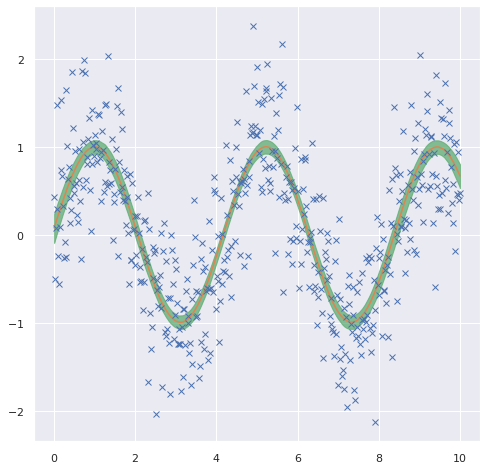

In [211]:
y_pred = []
for _, sample in result.posterior.sample(1000).iterrows():
#     print(sample)
    y_pred.append(modelB(time, **{k:sample[k] for k in likelihood_bilby.model_parameters.keys()}))
    
median = np.quantile(y_pred, 0.5, axis=0)
# print(median)
lower = np.quantile(y_pred, 0.01, axis=0)
upper = np.quantile(y_pred, 0.99, axis=0)

plt.figure(figsize = (8,8))
plt.plot(time, median, color='C1')
plt.fill_between(time, lower, upper, color="C2", alpha=0.7)

plt.plot(time, y_obs, 'x')
plt.show()

In [27]:
likelihood_bilby.model_parameters.keys()

dict_keys(['omega', 'A', 'phi_0'])

In [28]:
print(result.outdir)

/home/deepnika/Documents/Bilby/Tutorials/test-dir


In [31]:
! ls /home/deepnika/Documents/Bilby/Tutorials/test-dir

label_checkpoint_run.png    label_corner.png	  label_resume.pickle
label_checkpoint_stats.png  label_dynesty.pickle  label_samples.dat
label_checkpoint_trace.png  label_result.json


In [32]:
! head /home/deepnika/Documents/Bilby/Tutorials/test-dir/label_result.json

{
  "label": "label",
  "outdir": "/home/deepnika/Documents/Bilby/Tutorials/test-dir",
  "sampler": "dynesty",
  "log_evidence": -375.0292461474248,
  "log_evidence_err": 0.16777957472910826,
  "log_noise_evidence": NaN,
  "log_bayes_factor": NaN,
  "priors": {
    "A": {


In [33]:
! display /home/deepnika/Documents/Bilby/Tutorials/test-dir/label_checkpoint_trace.png

In [35]:
result_loaded = bilby.result.read_in_result("/home/deepnika/Documents/Bilby/Tutorials/test-dir/label_result.json")

In [36]:
print(result_loaded)
print(result_loaded.log_evidence)
print(result_loaded.injection_parameters)
print(result_loaded.sampling_time)
print(result_loaded.version)

nsamples: 18938
ln_noise_evidence:    nan
ln_evidence: -375.029 +/-  0.168
ln_bayes_factor:    nan +/-  0.168

-375.0292461474248
{'A': 1, 'omega': 1.5, 'phi_0': 0, 'sigma': 0.5}
26.486962
bilby=1.0.0: release


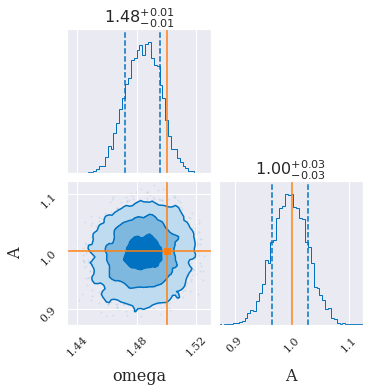

In [37]:
result.plot_corner(dict(omega = omega_true, A = 1))

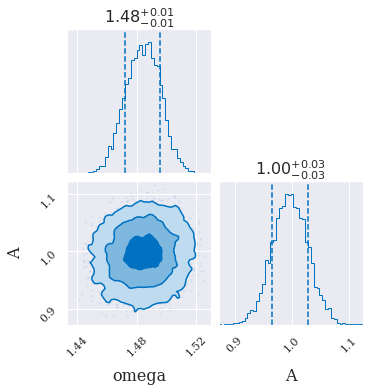

In [38]:
result.plot_corner(['omega', 'A'])

In [39]:
result.plot_marginals(['omega'], priors = True) # makes a directory label_1d

02:34 bilby INFO    : Plotting omega marginal distribution
02:34 bilby INFO    : Plotting omega marginal distribution


In [41]:
! display /home/deepnika/Documents/Bilby/Tutorials/test-dir/label_1d/omega_cdf.png

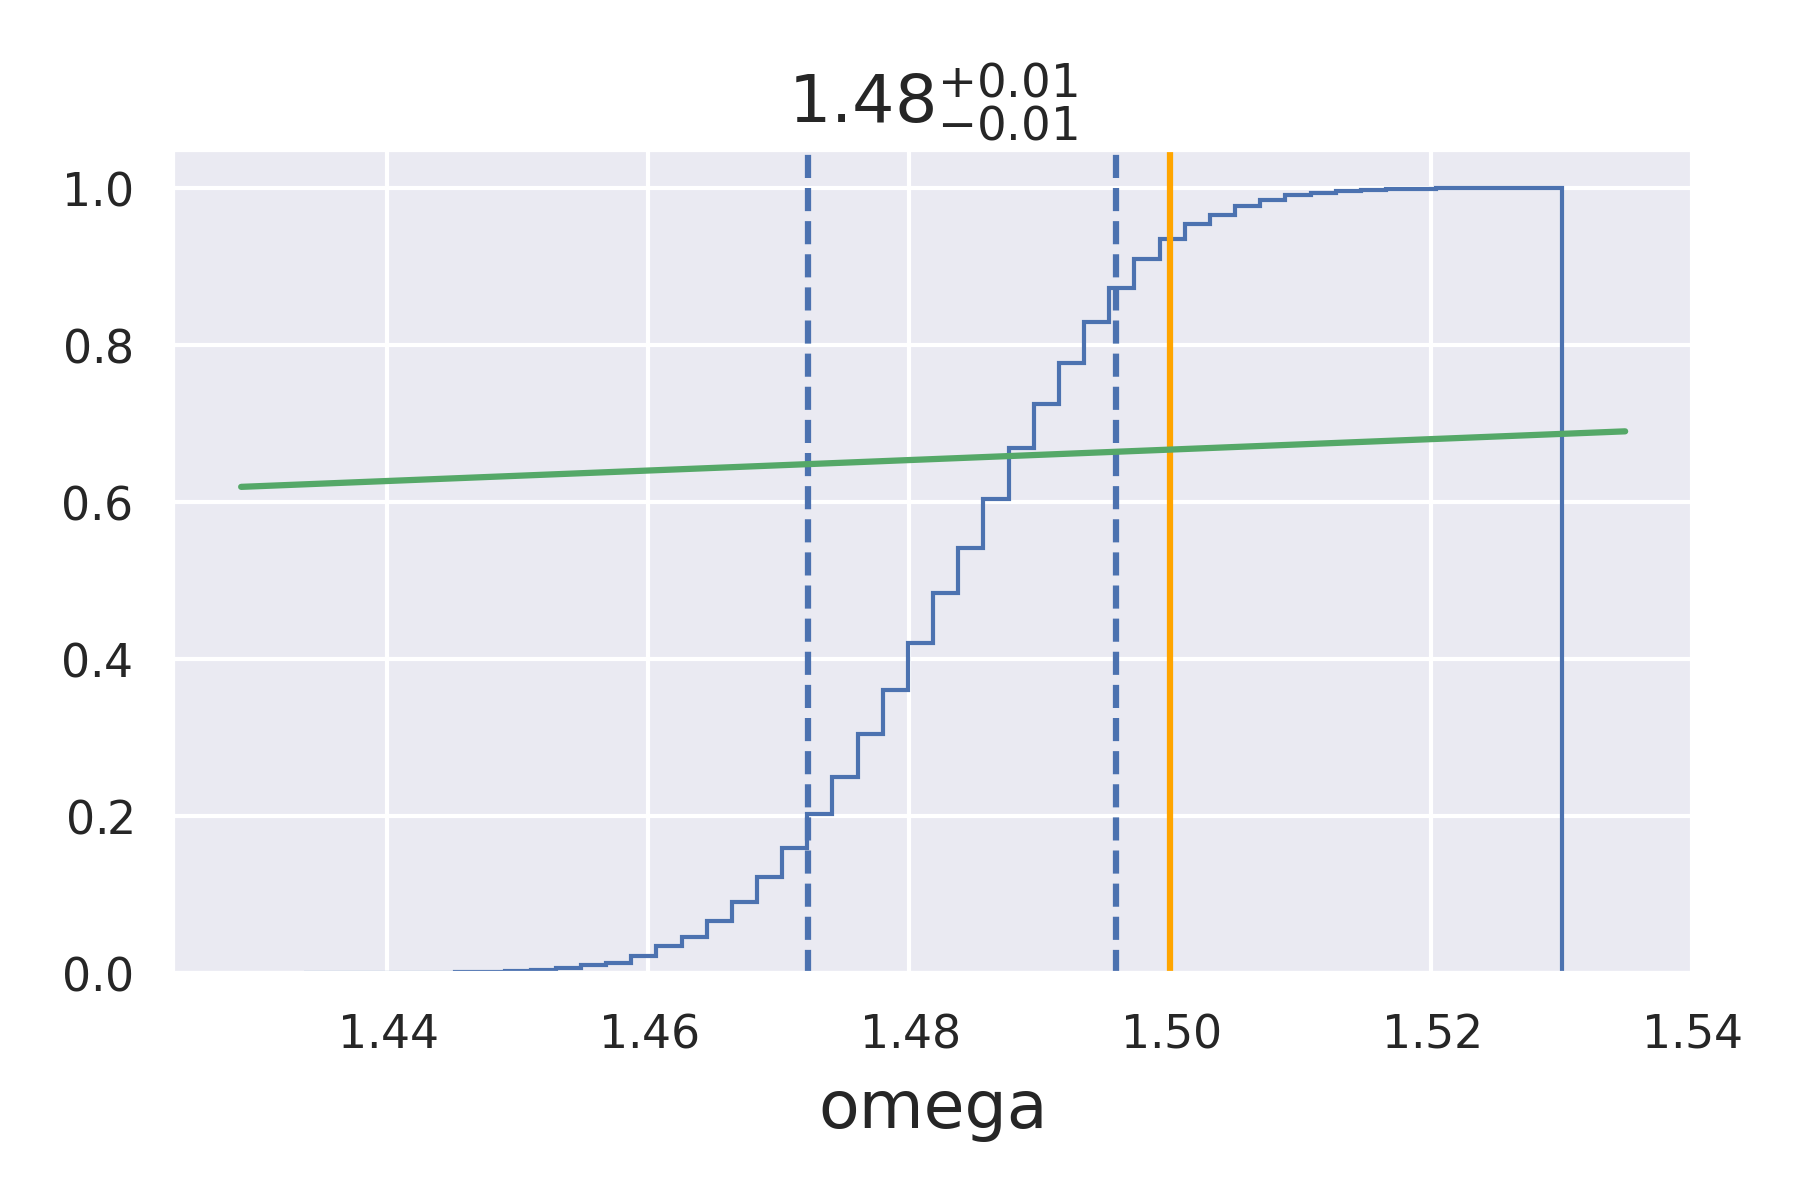

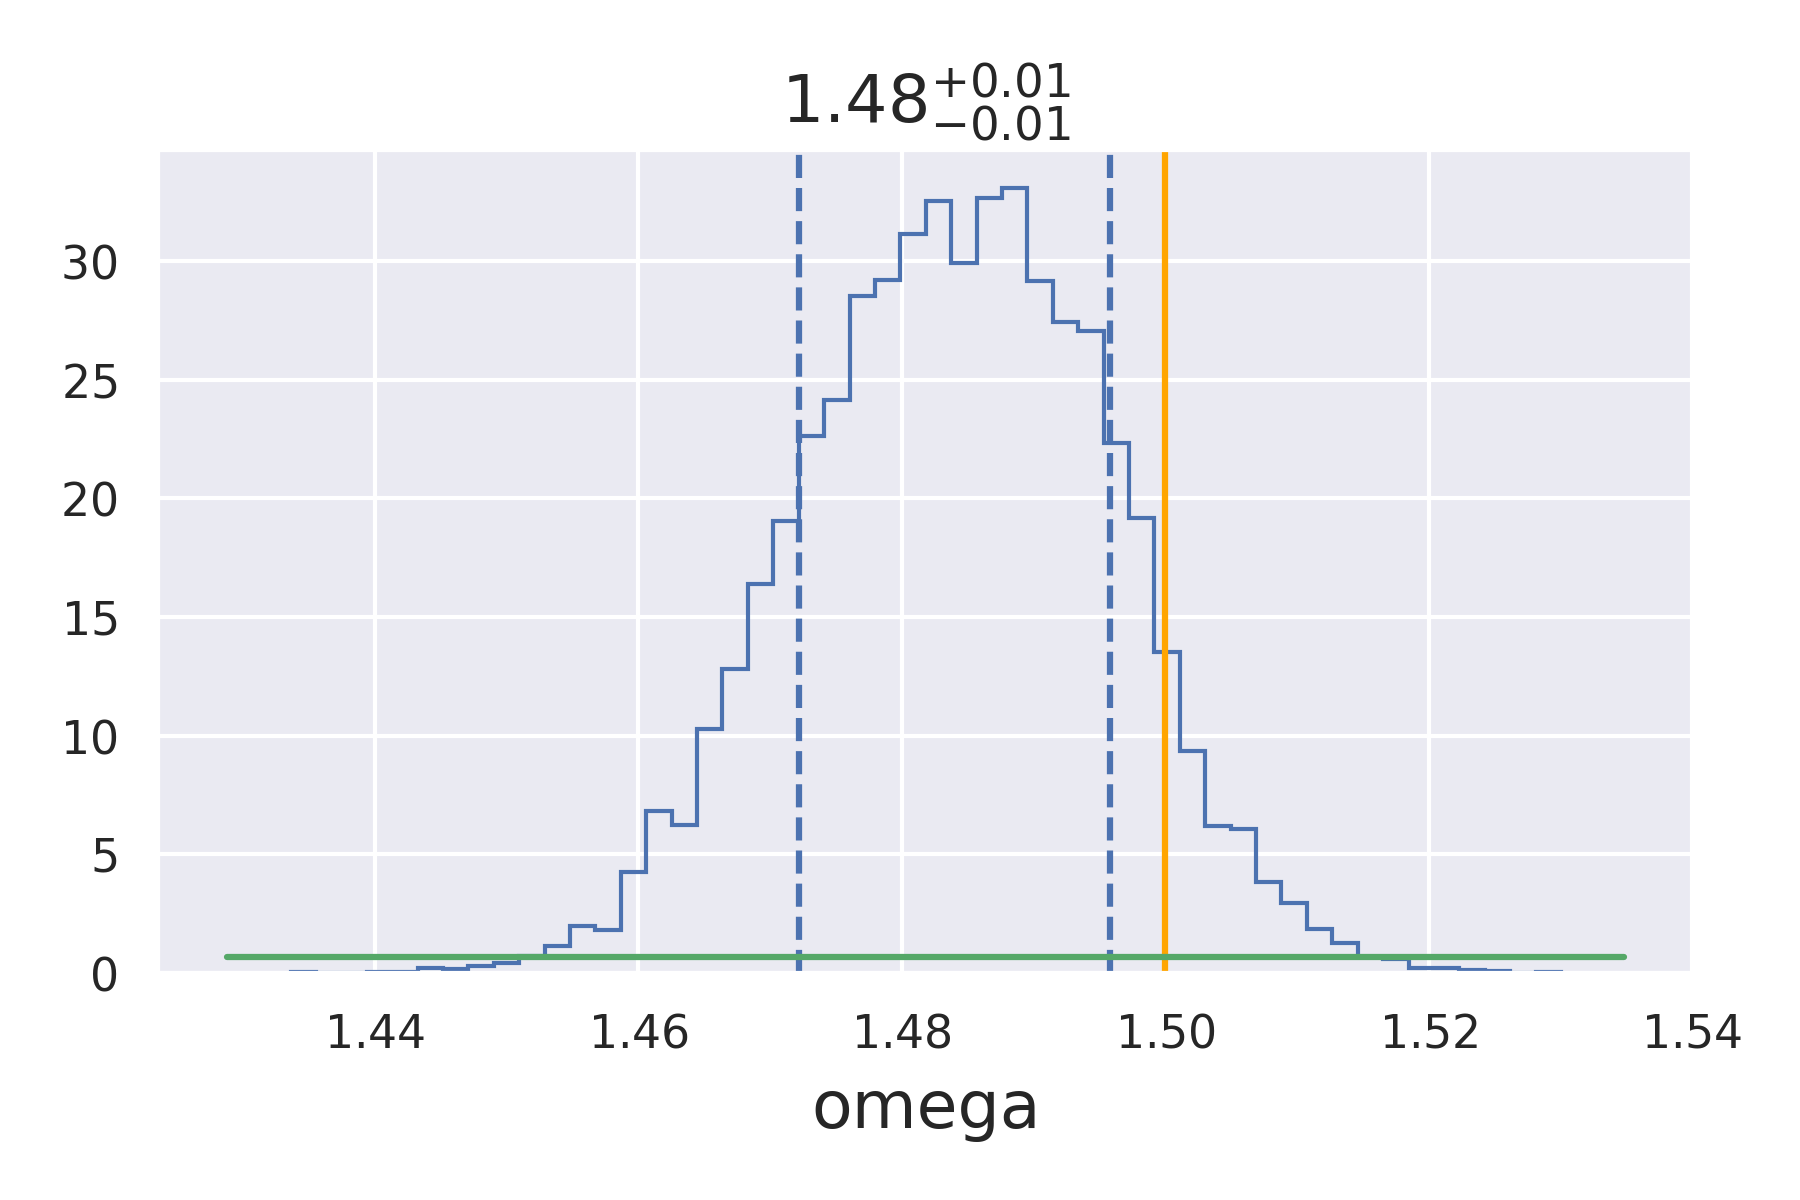

In [43]:
from IPython.display import Image 
cdf_img = Image(filename='/home/deepnika/Documents/Bilby/Tutorials/test-dir/label_1d/omega_cdf.png')
pdf_img = Image(filename = '/home/deepnika/Documents/Bilby/Tutorials/test-dir/label_1d/omega_pdf.png')
display(cdf_img)
display(pdf_img)

In [44]:
dir(likelihood_bilby)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_func',
 '_function_keys',
 '_marginalized_parameters',
 '_meta_data',
 '_sigma',
 '_x',
 '_y',
 'func',
 'function_keys',
 'log_likelihood',
 'log_likelihood_ratio',
 'marginalized_parameters',
 'meta_data',
 'model_parameters',
 'n',
 'noise_log_likelihood',
 'parameters',
 'residual',
 'sigma',
 'x',
 'y']

In [45]:
likelihood_bilby.log_likelihood()

-359.7544864312166

## Rough Cells

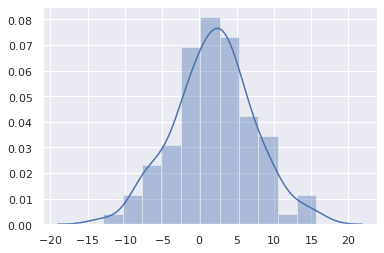

In [46]:
label = 'exotic'
outdir = 'outdir'

# here mean = 1, variance = 
data = np.random.normal(1, 5, 100)

# My likelihood function is p**4 * (1-p)**4

class ExoticLikelihood(bilby.Likelihood):
    def __init__(self, data):
        self.data = data
        self.N = len(data)
        
    def exotic_likelihood(self):
        p = self.data
        return p**2 * (1-p)**2
        

# plt.plot(data)
sns.distplot(data)
# r = ExoticLikelihood(data)
# sns.distplot(r.exotic_likelihood())
